In [1]:
import dask.dataframe as dd
from dask.dataframe import from_pandas
from dask.dataframe.utils import make_meta
from neo4j import GraphDatabase
from neo4j.exceptions import ClientError
from dask.distributed import Client, LocalCluster, get_worker
import dask

import os
import time
from tqdm import tqdm
import pandas as pd
import re

#importers
from pm4py import convert_to_event_log, convert_to_dataframe, format_dataframe

# Miners
from pm4py import discover_dfg_typed as dfg_discovery, serialize, deserialize
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.correlation_mining import algorithm as correlation_miner
from pm4py.algo.discovery.temporal_profile import algorithm as temporal_profile_discovery


# Evaluators
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

In [2]:
import sys
sys.setrecursionlimit(30000)

In [3]:
class graph_driver():
    def __init__(self, uri_scheme='bolt', host='localhost', port='7687', username='neo4j', password='123456'):
        self.uri_scheme = uri_scheme
        self.host = host
        self.port = port
        
        self.username = username
        self.password = password
        
        self.connection_uri = "{uri_scheme}://{host}:{port}".format(uri_scheme=self.uri_scheme, host=self.host, port=self.port)
        self.auth = (self.username, self.password)
        self.driver = GraphDatabase.driver(self.connection_uri, auth=self.auth)
        
    def __del__(self):
        self._close_driver()
    
    def _close_driver(self):
        if self.driver:
            self.driver.close()
    
    def run_single_query(self, query):
        res = None
        with self.driver.session() as session:
            raw_res = session.run(query)
            res = self.format_raw_res(raw_res)
        return res
    
    def run_bulk_query(self, query_list):
        results = []
        with self.driver.session() as session:
            for query in tqdm(query_list):
                raw_res = session.run(query)
                res = self.format_raw_res(raw_res)
                results.append({'query':query, 'result':res})
        return results
    
    def reset_graph(self, db=None):
        return self.run_single_query("MATCH (n) DETACH DELETE n")
    
    def test_connection(self):
        return self.run_single_query("MATCH (n) RETURN COUNT(n) as nodes")
    
    @staticmethod
    def format_raw_res(raw_res):
        res = []
        for r in raw_res:
            res.append(r)
        return res

In [4]:
client = Client(n_workers=4, threads_per_worker=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 64,Total memory: 7.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36611,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 7.67 GiB
Comm: tcp://127.0.0.1:36845,Total threads: 16
Dashboard: http://127.0.0.1:42091/status,Memory: 1.92 GiB
Nanny: tcp://127.0.0.1:36939,


In [5]:
columnTypes = {
    'case:IDofConceptCase': 'string',
    'case:Includes_subCases': 'string',
    'case:Responsible_actor': 'string',
    'case:caseProcedure': 'string',
    'case:concept:name': 'int64',
    'dateStop': 'string'
}
df = dd.read_csv('BPIC15_1.csv', dtype=columnTypes)
for column in df.columns:
    if re.search("[Dd]ate.*|time.*", column):
        df[column] = dask.dataframe.to_datetime(df[column], utc=True)

In [6]:
def getDFGQueries(dfg):
    listOfQueries = []
    queryTemplate = """
        MERGE (p:Activity {{name: '{parent}'}})
        MERGE (c:Activity {{name: '{child}'}})
        MERGE (p)-[r:PRODUCES]->(c)
        ON CREATE SET r.frequency={frequency}
        ON MATCH SET r.frequency=r.frequency+{frequency}
    """
    for parent, child in dfg:
        frequency = dfg[(parent, child)]
        template = queryTemplate.format(parent=parent, child=child, frequency=frequency)
        listOfQueries.append(template)
    return listOfQueries

In [7]:
def saveDFG(dfg):
    dfgResult = dfg_discovery(dfg)
    dfgQuery = getDFGQueries(dfgResult.graph)
    neo4jConnection = graph_driver(uri_scheme="neo4j",host="neo4j", password="123456")
    result = neo4jConnection.run_bulk_query(dfgQuery)
    return dfgResult

In [55]:
indxd = df.set_index('case:concept:name', drop=False, sorted=True)

In [50]:
indxd.index = indxd.index.rename('caseId')
indxd_prt = indxd.repartition(npartitions=4)

In [59]:
%%time
res = dask.compute(*indxd_prt.map_partitions(saveDFG).to_delayed(), scheduler='threads')

100% 1/1 [00:00<00:00, 45.29it/s]
/opt/conda/lib/python3.9/site-packages/dask/base.py:1368: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
  0% 0/363 [00:00<?, ?it/s]
  0% 0/777 [00:00<?, ?it/s]

  0% 0/915 [00:00<?, ?it/s]



  0% 0/950 [00:00<?, ?it/s]


  2% 8/363 [00:00<00:05, 61.46it/s]A
  1% 5/777 [00:00<00:15, 49.05it/s]

  1% 6/915 [00:00<00:15, 57.55it/s]



  1% 7/950 [00:00<00:14, 66.85it/s]


  6% 21/363 [00:00<00:03, 96.25it/s][A
  3% 23/777 [00:00<00:06, 124.71it/s]

  3% 23/915 [00:00<00:07, 121.85it/s]



  3% 24/950 [00:00<00:07, 124.56it/s]


 10% 37/363 [00:00<00:02, 122.05it/s]
  5% 41/777 [00:00<00:04, 148.76it/s]

  4% 38/915 [00:00<00:06, 132.12it/s]



  4% 38/950 [00:00<00:07, 128.85it/s]


 15% 53/363 [00:00<00:02, 133.43it/s]
  7% 56/777 [00:00<00:04, 148.31it/s]

  6% 52/915 [00:00<00:06, 134.91it/s]



  5% 51/950 [00:00<00:07, 127.70it/s]


 19% 69/363 [00:00<00:02, 

 59% 397/670 [00:02<00:01, 183.58it/s]


 11% 102/932 [00:00<00:04, 191.67it/s]

 81% 741/915 [00:04<00:01, 164.10it/s]
 99% 773/777 [00:04<00:00, 172.40it/s]



100% 777/777 [00:04<00:00, 174.74it/s]
 62% 417/670 [00:02<00:01, 183.66it/s]
  0% 0/842 [00:00<?, ?it/s]

 83% 758/915 [00:04<00:00, 164.42it/s]


 13% 122/932 [00:00<00:04, 184.24it/s]



 66% 439/670 [00:02<00:01, 192.67it/s]
  2% 18/842 [00:00<00:04, 178.42it/s]

 85% 775/915 [00:04<00:00, 163.91it/s]


 15% 143/932 [00:00<00:04, 189.37it/s]



 69% 461/670 [00:02<00:01, 199.87it/s]
  4% 37/842 [00:00<00:04, 182.20it/s]

 87% 793/915 [00:04<00:00, 166.69it/s]


 17% 163/932 [00:00<00:04, 187.53it/s]



 72% 482/670 [00:02<00:00, 202.69it/s]
  7% 56/842 [00:00<00:04, 183.36it/s]

 89% 811/915 [00:04<00:00, 168.40it/s]


 20% 182/932 [00:00<00:04, 182.99it/s]



 75% 503/670 [00:02<00:00, 191.09it/s]
  9% 75/842 [00:00<00:04, 179.95it/s]

 91% 829/915 [00:04<00:00, 170.97it/s]


 22% 201/932 [00:01<00:04, 180.26it/s]



 78%

 94% 694/735 [00:03<00:00, 199.89it/s]



 78% 642/819 [00:03<00:00, 216.89it/s]


  4% 20/554 [00:00<00:02, 192.33it/s]
 99% 837/842 [00:04<00:00, 180.01it/s]

100% 842/842 [00:04<00:00, 186.41it/s]




 81% 664/819 [00:03<00:00, 207.88it/s]
  0% 0/715 [00:00<?, ?it/s]


  7% 40/554 [00:00<00:02, 187.01it/s]

100% 735/735 [00:03<00:00, 201.43it/s]


  0% 0/544 [00:00<?, ?it/s]
  3% 21/715 [00:00<00:03, 208.16it/s]



 99% 736/744 [00:03<00:00, 189.47it/s]


100% 744/744 [00:03<00:00, 206.39it/s][A


  4% 21/544 [00:00<00:02, 206.17it/s]



  0% 0/397 [00:00<?, ?it/s]
  6% 42/715 [00:00<00:03, 190.03it/s]


 86% 705/819 [00:03<00:00, 193.07it/s][A



  6% 22/397 [00:00<00:01, 218.81it/s]

  8% 42/544 [00:00<00:02, 201.13it/s]
  9% 64/715 [00:00<00:03, 196.97it/s]


 89% 726/819 [00:03<00:00, 196.95it/s]



 11% 44/397 [00:00<00:01, 197.88it/s]

 12% 63/544 [00:00<00:02, 189.85it/s]


 22% 124/554 [00:00<00:02, 205.62it/s]
 91% 746/819 [00:03<00:00, 191.90it/s][A



 16% 64/397 [00:00<0

CPU times: user 5.78 s, sys: 1.68 s, total: 7.46 s
Wall time: 12.8 s


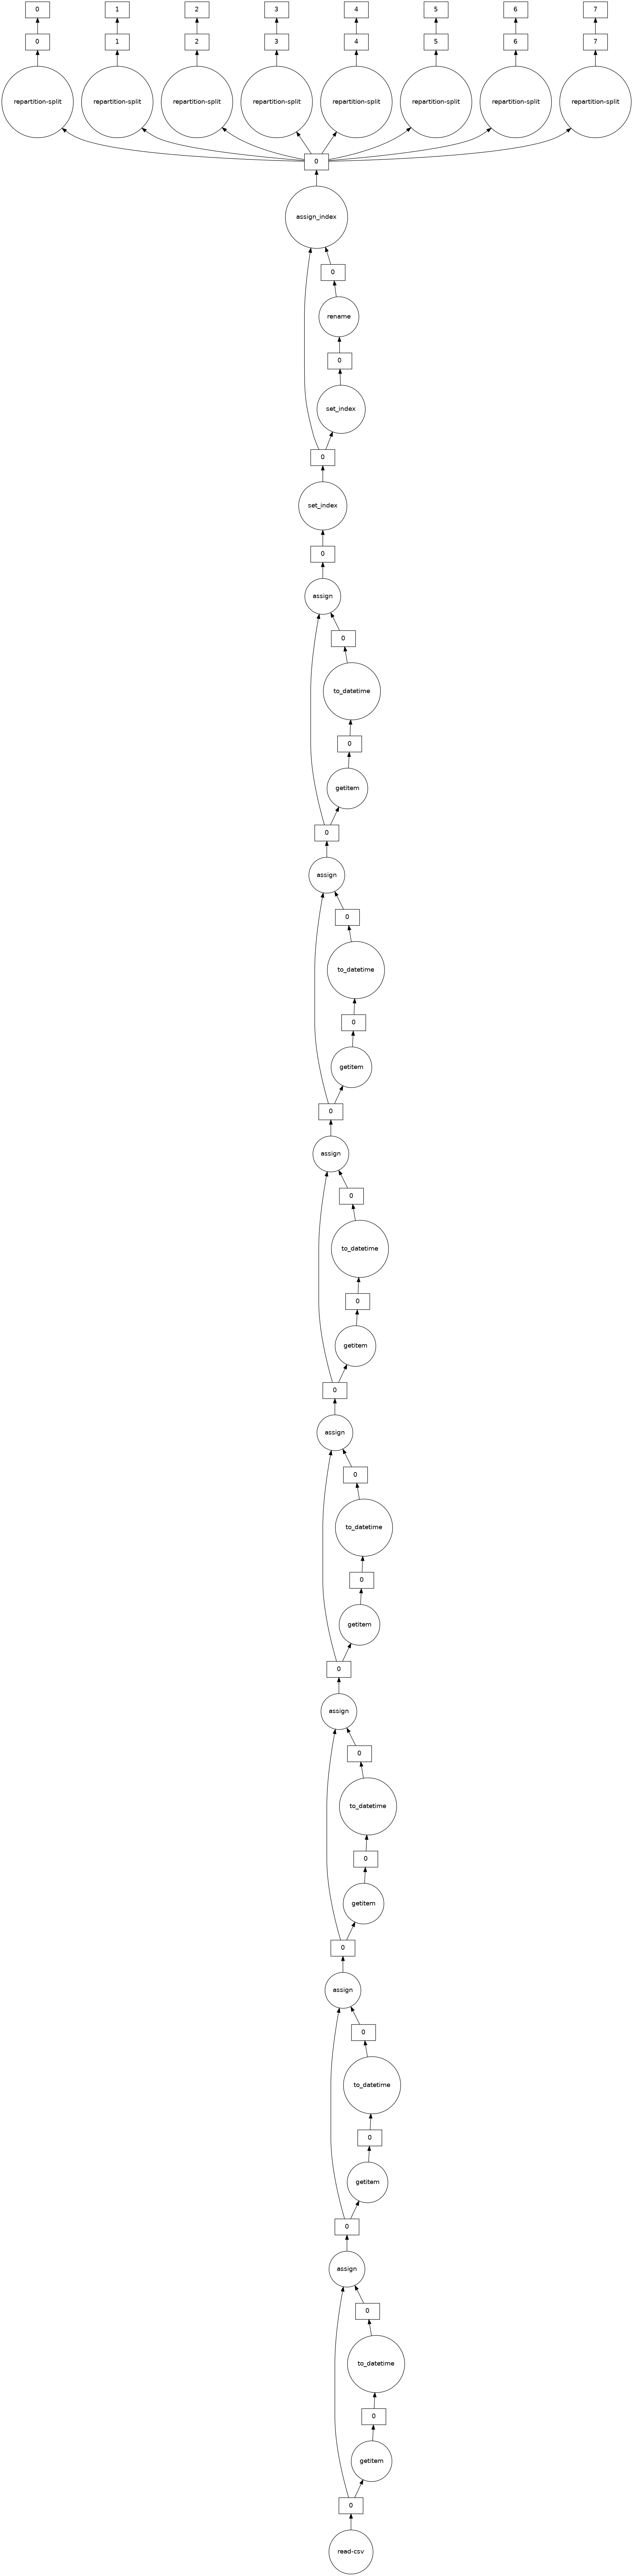

In [47]:
indxd_prt.visualize()

In [56]:
# test = df.groupby('case:concept:name')

In [57]:
# %%time
# x = dask.compute(*test.apply(saveDFG).to_delayed())

In [106]:
lazyDFG = dask.delayed(saveDFG)(df)

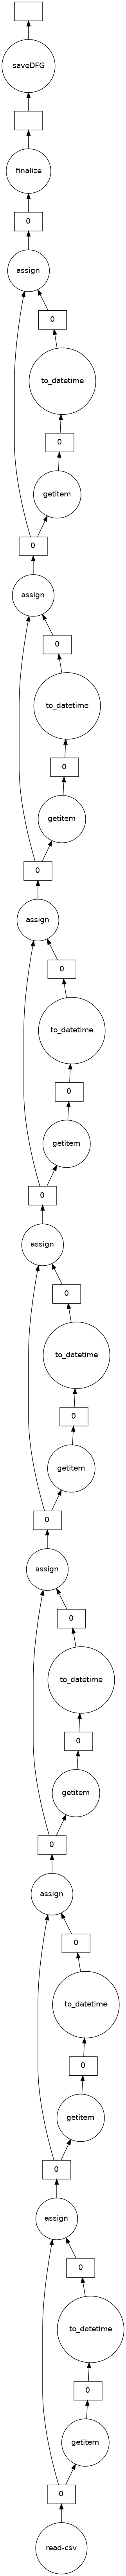

In [107]:
lazyDFG.visualize()

In [108]:
dfg_output = dask.compute(lazyDFG)[0] # hosted locally

100%|██████████| 4699/4699 [00:20<00:00, 230.01it/s]


In [78]:
def getMinerResult(dfg, miner, threshold = 0.5):
    result = {}
    if miner == 'heuristic_miner':
        net, im, fm = heuristics_miner.apply_dfg(dfg, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: threshold})
    elif miner == 'inductive_miner':
        net, im, fm = inductive_miner.apply_dfg(dfg, noise_threshold=0.9, multi_processing=True)
    elif miner == 'alpha_miner':
        net, im, fm = alpha_miner.apply_dfg(dfg)
    
    result[miner] = serialize(net, im, fm)
    return result
    
def setLazyMiners(dfg):
    lazyList = []
    miners = [
        'heuristic_miner', 
#         'inductive_miner',
#         'alpha_miner'
    ]
    for miner in miners:
        task = dask.delayed(getMinerResult)(dfg, miner)
        lazyList.append(task)
    
    return lazyList

In [80]:
def getMetrics(metric, log, petrinet, im, fm):
    result = {}
    if metric == 'fitness':
        result[metric] = replay_fitness_evaluator.apply(log, petrinet, im, fm, variant=replay_fitness_evaluator.TOKEN_BASED)
    elif metric == 'simplicity':
        result[metric] = simplicity_evaluator.apply(petrinet)
    elif metric == 'precision':
        result[metric] = precision_evaluator.apply(log, petrinet, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
    elif metric == 'generalization':
        result[metric] = generalization_evaluator.apply(log, petrinet, im, fm)
    
    return result

def setLazyMetrics(dfg, petrinet, im, fm):
    lazyList = []
    metrics = [
        'fitness', 
#         'simplicity', 
#         'precision', 
#         'generalization'
    ]
    
    for metric in metrics:
        task = dask.delayed(getMetrics)(metric, dfg, petrinet, im, fm)
        lazyList.append(task)
    
    return lazyList

In [74]:
lazyMiners = setLazyMiners(dfg_output.graph)

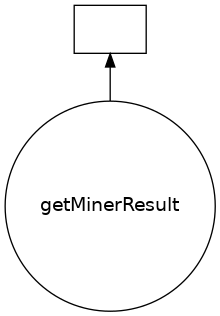

In [77]:
lazyMiners[0].visualize()

In [60]:
lazyMinersResults = dask.compute(*lazyMiners)

In [61]:
net, im, fm = deserialize(lazyMinersResults[0]['heuristic_miner'])

In [62]:
lazyMetrics = setLazyMetrics(df, net, im, fm)

In [63]:
lazyMetricsResults = dask.compute(*lazyMetrics)

replaying log with TBR, completed variants ::   2%|▏         | 23/1180 [00:43<1:10:31,  3.66s/it]2023-01-24 17:17:01,108 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-24 17:17:01,117 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-24 17:17:01,118 - distributed.nanny - ERROR - Worker process died unexpectedly


KeyboardInterrupt: 